In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from datetime import datetime
from tensorflow import keras
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import os
# plt.style.use('science')
# os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
# plt.style.use(['science','ieee'])

In [14]:
# Convert dataframe to a tf.data.Dataset
global train, test, train_ds, test_ds
def df_to_dataset(dataframe, shuffle=True, batch_size=20):
  import tensorflow as tf
  dataframe1 = dataframe.copy()
  labels = dataframe1.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe1), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe1))
  ds = ds.batch(batch_size)
  return ds

In [85]:
# SVM model
def modify_label(label):
    if label == 0:
        return -1
    return label

def svm_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    df['label'] = df['label'].map(modify_label)
    labels = df['label'].values
    features = df.drop(['label','file_id', 'Unnamed: 0'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

In [115]:
# Logistic Regression model
def lr_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label','file_id'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.4)
    
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

In [86]:
# K-Nearest Neighbors model
def knn_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label','file_id'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)
    
    knn = KNeighborsClassifier(n_neighbors=50)
    
    clf = knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

In [90]:
# Random Forest model
def rf_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label','file_id'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)
    
    rf = RandomForestClassifier(random_state=0, n_estimators=1)
    
    clf = rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

In [12]:
# Training Model
def train_model(data):
    import tensorflow as tf
    global train, test, train_ds, test_ds
    if data is None:
        return None
    if len(data.columns) == 0:
        return None
    feature_columns = []
    for feature in data.columns:
        if feature == 'label':
            continue
        feature_columns.append(tf.feature_column.numeric_column(feature))
    
    batch_size=20
    train, test = train_test_split(data, test_size=0.2)
    train_ds = df_to_dataset(train, batch_size=batch_size)
    test_ds = df_to_dataset(test, batch_size=batch_size)
    
    model = tf.keras.Sequential([
          tf.keras.layers.DenseFeatures(feature_columns),
          #tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy', 'Recall', 'Precision'])
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    model.fit(train_ds,
          validation_data = test_ds,
          epochs = 100,
          callbacks = [tensorboard_callback])
    return model

In [15]:
# Deep Learning Model training on choosen features
def deep_model_train():
    feature_df = pd.read_csv('TCGA_Labeled_Final_Features.csv', index_col=0)
    df_t2 = shuffle(feature_df)
    return train_model(df_t2)

model = deep_model_train()

Epoch 1/100
24/24 [==============================] - 14s 238ms/step - loss: 8077.4146 - auc: 0.7291 - accuracy: 0.5074 - recall: 0.4558 - precision: 1.0000 - val_loss: 5406.4668 - val_auc: 0.8000 - val_accuracy: 0.6471 - val_recall: 0.6000 - val_precision: 1.0000
Epoch 2/100
24/24 [==============================] - 1s 22ms/step - loss: 5901.5620 - auc: 0.8244 - accuracy: 0.6821 - recall: 0.6488 - precision: 1.0000 - val_loss: 3606.9941 - val_auc: 0.8714 - val_accuracy: 0.7731 - val_recall: 0.7429 - val_precision: 1.0000
Epoch 3/100
24/24 [==============================] - 1s 23ms/step - loss: 4429.4487 - auc: 0.8807 - accuracy: 0.8021 - recall: 0.7837 - precision: 0.9970 - val_loss: 2489.8203 - val_auc: 0.8952 - val_accuracy: 0.8151 - val_recall: 0.7905 - val_precision: 1.0000
Epoch 4/100
24/24 [==============================] - 1s 23ms/step - loss: 3543.8552 - auc: 0.9156 - accuracy: 0.8653 - recall: 0.8535 - precision: 0.9973 - val_loss: 1558.4170 - val_auc: 0.9381 - val_accuracy: 0.

In [16]:
# Saving the deep learning model for future use
model.save('Model/model.h5')


In [119]:
# Testing the Deep Learning Model now
import tensorflow as tf
x = tf.data.Dataset.from_tensor_slices(test.drop(['label'], axis = 1).to_dict('list'))
x1 = x.batch(10)
pp = model.predict(x1)
DNN_fpr, DNN_tpr, DNN_thresholds = roc_curve(test['label'].values, pp)
auc(DNN_fpr, DNN_tpr)

12/12 [==============================] - 1s 19ms/step


0.9142857142857144

In [96]:
svm_fpr,svm_tpr,thre = svm_train()
auc(svm_fpr, svm_tpr)

0.8792665214233841

In [125]:
lr_fpr,lr_tpr,thre = lr_train()
auc(lr_fpr,lr_tpr)

0.9385321100917431

In [97]:
knn_fpr,knn_tpr,thre = knn_train()
auc(knn_fpr,knn_tpr)

0.8688650306748467

In [93]:
rf_fpr,rf_tpr,thre = rf_train()
auc(rf_fpr,rf_tpr)

0.8588709677419355

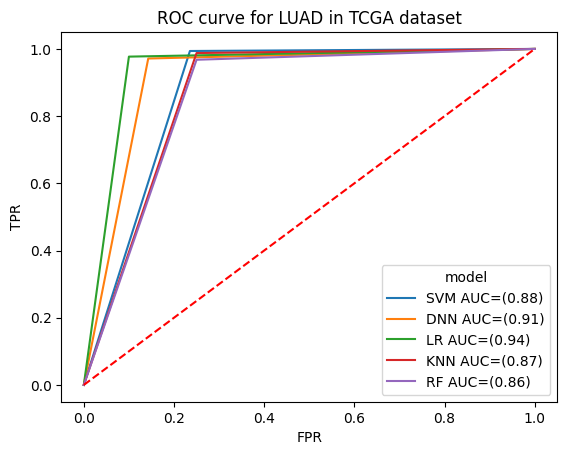

In [126]:
# Comparing the ROC curves of all the models
# with plt.style.context(['science']):
fig, ax = plt.subplots()        
for p in ['SVM', 'DNN','LR','KNN','RF']: 
    fpr, tpr = get_ff(p)
    roc_auc=auc(fpr, tpr)
    ax.plot(fpr, tpr, label='%s AUC=(%.2f)' %(p, roc_auc)) 
ax.plot([0,1],[0,1],'r--')
ax.legend(loc='lower right') 
ax.legend(title='model')       
ax.set(xlabel='FPR')        
ax.set(ylabel='TPR')
plt.title('ROC curve for LUAD in TCGA dataset')      
fig.savefig('fig1.jpg', dpi=300)

In [38]:
def get_ff(model_name):
    if model_name == 'SVM':
        return svm_fpr, svm_tpr
    if model_name == 'DNN':
        return DNN_fpr, DNN_tpr
    if model_name == 'LR':
        return lr_fpr, lr_tpr
    if model_name == 'KNN':
        return knn_fpr, knn_tpr
    if model_name == 'RF':
        return rf_fpr, rf_tpr